In [1]:
import xarray as xr
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import scipy.stats as sps

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
from matplotlib import ticker
from matplotlib import rc
import brewer2mpl
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

colors={'direct':'#3d7f1e',
        'indirect':'#b1116d',
        'total':'darkorange'
        }

from sklearn.linear_model import LinearRegression

set2 = brewer2mpl.get_map('Set1', 'qualitative', 9).mpl_colors

In [2]:
macsp = xr.open_dataset('../../datasets/MAC-SP.nc')

emissions = pd.DataFrame({
    'Europe': [8.95, 18.26, 56.80, 16.41, 11.35],
    'North America': [7.65, 24.09, 29.32, 17.45, 7.39],
    'East Asia': [0.17, 1.69, 14.72, 37.36, 34.89],
    'South Asia': [0.18, 1.57, 9.18, 17.17, 22.89],
    'North Africa': [0.08, 0.20, 1.02, 1.70, 1.94],
    'South America': [0.12, 1.24, 4.81, 4.88, 5.26],
    'Maritime Continent': [0.03, 0.22, 2.13, 4.15, 4.43],
    'South Central Africa': [0.04, 1.42, 3.83, 3.35, 4.29],
    'Australia': [0.23, 0.63, 1.61, 1.57, 1.39],
    #'Global': [17.54, 49.32, 123.42, 104.04, 70.94]
},
index=[1900, 1950, 1980, 2005, 2013])

emission = pd.DataFrame({
    'Global': [17.54, 49.32, 123.42, 104.04, 93.83]
},
index=[1900, 1950, 1980, 2005, 2013])

sum = macsp.year_weight.sel(plume_number=1).isel(years=slice(0,164)).values * 0
for year in range(0, 164, 1):
    for plume_number in range(1, 10 ,1):
        sum[year] = sum[year] + macsp.year_weight.sel(plume_number=plume_number).isel(years=year)*emissions.iloc[:, plume_number-1].loc[2005]

def WeightedMean(var):
    weights = np.cos(np.deg2rad(var.lat))
    if len(var.shape) >= 2:
        return var.weighted(weights).mean(dim=('lat', 'lon'))
    else:
        return var.weighted(weights).mean("lat")

In [ ]:
coefs = pd.DataFrame({'Direct': [1,0,0,0,0,0,0,0,0],
                'Clear-sky': [60,0,0,0,0,0,0,0,0]},
                index=['Europe', 'North America', 'East Asia', 'South Asia', 'North Africa', 'South America', 'Maritime Continent', 'South Central Africa',
'Australia'])

coefs['Clear-sky']

3.4233577856445647


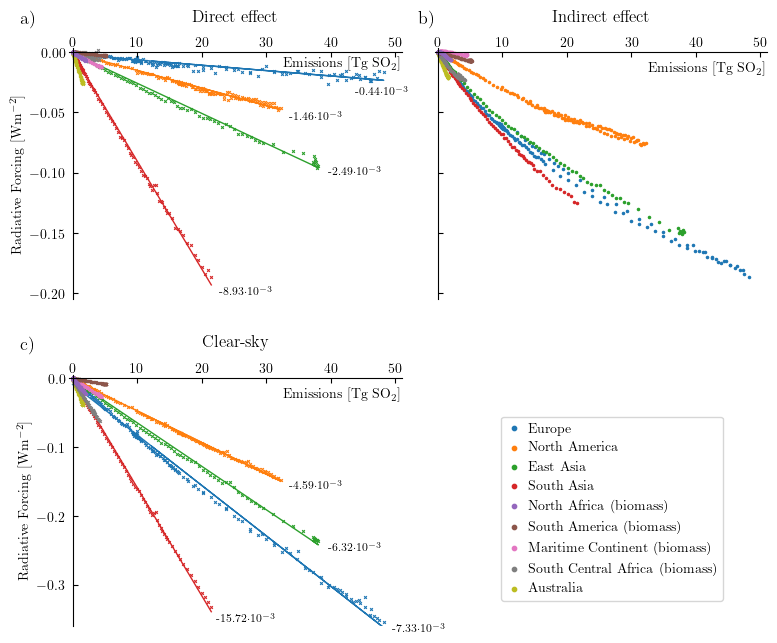

In [9]:
def plot_figure():

    dataset = xr.open_dataset('../../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['direct', 'indirect','clear-sky']

    for ax in [ax1, ax2, ax3]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_position('zero')
        for k, spine in ax.spines.items():
            spine.set_zorder(20)
        ax.set_xlim([-0.5, 51])
        


    zorder = [1, 4, 3, 2, 9, 8, 7, 6, 5]

    coefs = pd.DataFrame({'direct': [0,0,0,0,0,0,0,0,0],
                  'clear-sky': [0,0,0,0,0,0,0,0,0]},
                   index=['Europe', 'North America', 'East Asia', 'South Asia', 'North Africa', 'South America', 'Maritime Continent', 'South Central Africa',
    'Australia'])

    ms=4
    for effect in effects:
        for plume_number in range(1, 10, 1):
            label=macsp.attrs[f'plume{plume_number}_region']
            #color = set2[plume_number-1]
            if effect == 'total':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_sp{plume_number}_srad0'] + dataset[f'dR_sp{plume_number}_trad0'], label=label, s=ms, zorder=zorder[plume_number-1])
            elif effect == 'direct':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0'], label=label, s=ms, zorder=zorder[plume_number-1], marker='x', linewidths=0.8)
                
                X = macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005]
                x = X.values.reshape(-1, 1)
                y = dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0']
                reg = LinearRegression().fit(x, y)
                subplots[effect].plot(x, x*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
                coefs['direct'][label] = reg.coef_

            elif effect == 'indirect':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_spi{plume_number}_srad0'] + dataset[f'dR_spi{plume_number}_trad0'], label=label, s=ms*0.6, zorder=zorder[plume_number-1])#, marker='x', linewidths=0.8)
            
            elif effect == 'clear-sky':
                subplots[effect].scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_spd{plume_number}_sraf0'] + dataset[f'dR_spd{plume_number}_traf0'], label=label, s=ms, zorder=zorder[plume_number-1], marker='x', linewidths=0.8)
                
                X = macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005]
                x = X.values.reshape(-1, 1)
                y = dataset[f'dR_spd{plume_number}_sraf0'] + dataset[f'dR_spd{plume_number}_traf0']
                reg = LinearRegression().fit(x, y)
                subplots[effect].plot(x, x*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
                coefs['clear-sky'][label] = reg.coef_

    print(coefs['clear-sky']['South Asia']/coefs['clear-sky']['North America'])

    ax1.annotate(str(round(coefs['direct']['Europe']*1000,2))+r'$\cdot10^{-3}$', [0.86, 0.82],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['North America']*1000,2))+r'$\cdot10^{-3}$', [0.66, 0.72],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['East Asia']*1000,2))+r'$\cdot10^{-3}$', [0.78, 0.5],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['South Asia']*1000,2))+r'$\cdot10^{-3}$', [0.45, 0.02],xycoords="axes fraction", fontsize=8)

    ax3.annotate(str(round(coefs['clear-sky']['Europe']*1000,2))+r'$\cdot10^{-3}$', [0.97, -0.02],xycoords="axes fraction", fontsize=8)
    ax3.annotate(str(round(coefs['clear-sky']['North America']*1000,2))+r'$\cdot10^{-3}$', [0.66, 0.55],xycoords="axes fraction", fontsize=8)
    ax3.annotate(str(round(coefs['clear-sky']['East Asia']*1000,2))+r'$\cdot10^{-3}$', [0.78, 0.3],xycoords="axes fraction", fontsize=8)
    ax3.annotate(str(round(coefs['clear-sky']['South Asia']*1000,2))+r'$\cdot10^{-3}$', [0.44, 0.02],xycoords="axes fraction", fontsize=8)
    
    ax1.set_title('Direct effect', pad=20)
    ax1.annotate('a)', [-0.15, 1.1],xycoords="axes fraction", fontsize=13)
    ax1.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax1.xaxis.set_label_coords(.82, .97)
    ax1.set_ylim([-0.205, 0.003])
    ax1.set_yticks([-0.2, -.15, -0.1, -0.05, 0])
    ax1.set_ylabel("Radiative Forcing [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='out', which='major', pad=-15)
    ax1.tick_params(axis='y', direction='in', which='both', pad=5)
   
    ax2.annotate('b)', [-0.05, 1.1],xycoords="axes fraction", fontsize=13)
    ax2.set_title('Indirect effect', pad=20)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.2, 0.01])
    ax2.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax2.xaxis.set_label_coords(.82, .95)
    ax2.set_ylim([-0.205, 0.003])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='out', which='major', pad=-15)
    ax2.tick_params(axis='y', labelleft=False, which='both', direction='in')

    ax3.annotate('c)', [-0.15, 1.1],xycoords="axes fraction", fontsize=13)
    ax3.set_title('Clear-sky', pad=20)
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.xaxis.set_label_coords(.82, .95)
    ax3.set_ylim([-0.36, 0.005])
    ax3.set_yticks([-0.3, -.2, -0.1, 0])
    ax3.set_ylabel("Radiative Forcing [Wm$^{-2}$]")  
    ax3.tick_params(axis='x', direction='out', which='major', pad=-15)
    ax3.tick_params(axis='y', direction='in', which='both', pad=5)

   
    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.2,-1.2), markerscale=2)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    
    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    #plt.tight_layout()
    plt.savefig(f'../../figures/archives/forcing-vs-emissions-individual-plumes.pdf', bbox_inches='tight')

plot_figure()

Europe[-0.00044406]-0.0021019983  score = 0.8975755890409857
North America[-0.00145729]-0.000737248  score = 0.9925945801587758
East Asia[-0.00249322]-0.00095280074  score = 0.9961914977657084
South Asia[-0.00892802]-0.00097636133  score = 0.9989245716246155
North Africa (biomass)[-0.00348765]-6.385753e-05  score = 0.9897608188126635
South America (biomass)[-0.00058262]-2.3109955e-05  score = 0.9858962218577332
Maritime Continent (biomass)[-0.00284842]-6.0254242e-05  score = 0.9989630974051253
South Central Africa (biomass)[-0.00122286]-5.2945223e-05  score = 0.6999984995509507
Australia[-0.01653052]-0.00015379023  score = 0.9995254021581018


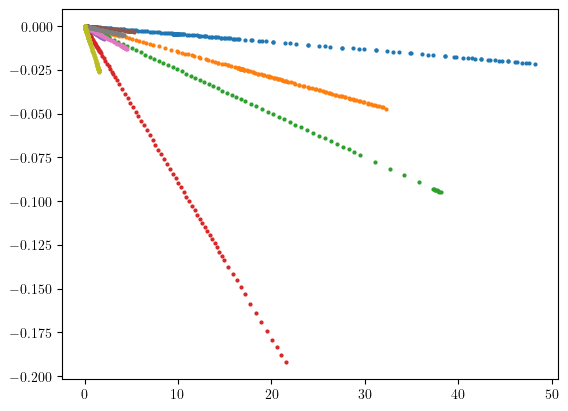

In [29]:
def regression():
    dataset = xr.open_dataset('../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()
    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']
        X = macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005]
        x = X.values.reshape(-1, 1)
        y = dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0']
        reg = LinearRegression().fit(x, y)
        print(label + str(reg.coef_) + str(reg.intercept_) + '  score = ' + str(reg.score(x,y)))

        plt.scatter(x, x*reg.coef_, s=4)
    

regression()

1.0768163010618852


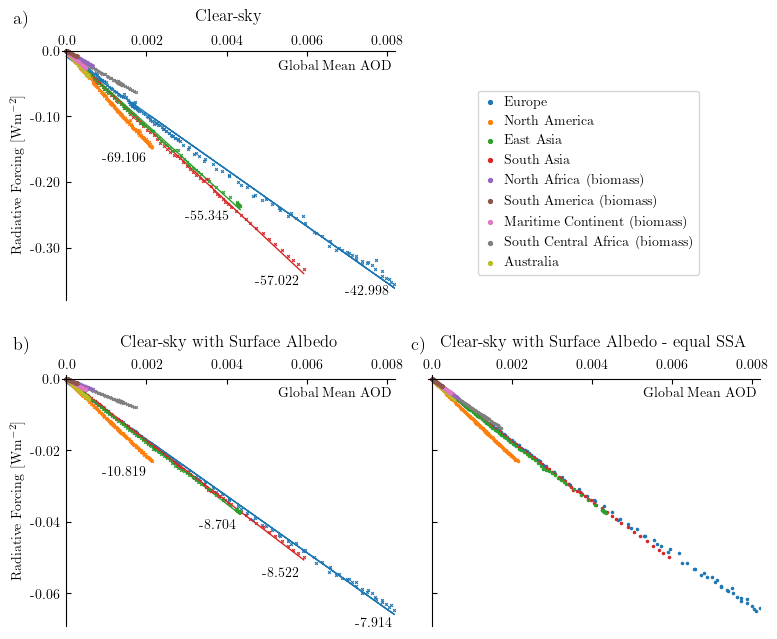

In [7]:
def plot_figure():

    dataset = xr.open_dataset('../../datasets/historical_simple-plumes_yearmean.nc').squeeze()

    ssa = xr.open_dataset('../../fmbg_ssa/datasets/temp.nc').squeeze()

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax3 = fig.add_subplot(gs[1, 1], sharey=ax2, sharex=ax1)
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['clear-sky', 'clear-sky-alb','ssa']

    for ax in [ax1, ax2, ax3]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_position('zero')
        for k, spine in ax.spines.items():
            spine.set_zorder(20)
        ax.set_xlim([-0.0001, 0.0082])

    zorder = [1, 4, 3, 2, 7, 9, 8, 6, 5]

    coefs = pd.DataFrame({'clear-sky': [0,0,0,0,0,0,0,0,0],
                  'clear-sky-alb': [0,0,0,0,0,0,0,0,0]},
                   index=['Europe', 'North America', 'East Asia', 'South Asia', 'North Africa', 'South America', 'Maritime Continent', 'South Central Africa',
    'Australia'])

    ms=4
    for effect in effects:
        for plume_number in range(1, 10, 1):
            label=macsp.attrs[f'plume{plume_number}_region']

            
            #direct = dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0']
            clearsky = dataset[f'dR_spd{plume_number}_sraf0'] + dataset[f'dR_spd{plume_number}_traf0']
            aod = dataset[f'aod_sp{plume_number}']
            #albedo = - dataset.sradsu /(dataset.srads - dataset.sradsu) #all-sky albedo
            albedo = - (dataset.sraf0 - dataset.srad0d)/(dataset.srad0d)  #clear-sky albedo

            #albedo_ssa = - ssa.sradsu /(ssa.srads - ssa.sradsu)
            albedo_ssa = - (ssa.sraf0 - ssa.srad0d)/(ssa.srad0d)

            clearsky_ssa = ssa[f'dR_spd{plume_number}_sraf0'] + ssa[f'dR_spd{plume_number}_traf0']
            if effect == 'clear-sky':
                X = WeightedMean(aod)
                x = X.values.reshape(-1, 1)
                y = WeightedMean(clearsky)
                reg = LinearRegression().fit(x, y)

                ax1.scatter(X, y, label=label, s=ms, zorder=zorder[plume_number-1], marker='x', linewidths=0.8)
                ax1.plot(x, x*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
                coefs['clear-sky'][label] = reg.coef_

            if effect == 'clear-sky-alb':
                X = WeightedMean(aod)
                x = X.values.reshape(-1, 1)
                y = WeightedMean(clearsky*(albedo))#/WeightedMean(albedo)
                reg = LinearRegression().fit(x, y)
                ax2.scatter(X, y, label=label, s=ms, zorder=zorder[plume_number-1], marker='x', linewidths=0.8)
                ax2.plot(x, x*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
                coefs['clear-sky-alb'][label] = reg.coef_


            if effect == 'ssa':
                ax3.scatter(WeightedMean(ssa[f'aod_sp{plume_number}']), WeightedMean(clearsky_ssa*albedo_ssa), label=label, s=ms*0.6, zorder=zorder[plume_number-1])

    print(coefs['clear-sky-alb']['South Asia']/coefs['clear-sky-alb']['Europe'])

    ax1.annotate(str(round(coefs['clear-sky']['Europe'],3)), [0.85, 0.02],xycoords="axes fraction", fontsize=10)
    ax1.annotate(str(round(coefs['clear-sky']['North America'],3)), [0.12, 0.55],xycoords="axes fraction", fontsize=10)
    ax1.annotate(str(round(coefs['clear-sky']['East Asia'],3)), [0.37, 0.32],xycoords="axes fraction", fontsize=10)
    ax1.annotate(str(round(coefs['clear-sky']['South Asia'],3)), [0.58, 0.06],xycoords="axes fraction", fontsize=10)

    ax2.annotate(str(round(coefs['clear-sky-alb']['Europe'],3)), [0.88, 0.0],xycoords="axes fraction", fontsize=10)
    ax2.annotate(str(round(coefs['clear-sky-alb']['North America'],3)), [0.12, 0.6],xycoords="axes fraction", fontsize=10)
    ax2.annotate(str(round(coefs['clear-sky-alb']['East Asia'],3)), [0.41, 0.39],xycoords="axes fraction", fontsize=10)
    ax2.annotate(str(round(coefs['clear-sky-alb']['South Asia'],3)), [0.6, 0.2],xycoords="axes fraction", fontsize=10)

    ax1.annotate('a)', [-0.15, 1.1],xycoords="axes fraction", fontsize=13)
    ax1.set_title('Clear-sky', pad=20)
    ax1.set_xlabel(r"Global Mean AOD")
    ax1.xaxis.set_label_coords(.82, .95)  
    ax1.set_yticks([-0.3, -0.2, -0.1, 0])
    ax1.set_ylim([None, 0.003])
    ax1.set_ylabel("Radiative Forcing [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='out', which='major', pad=-15)
    ax1.tick_params(axis='y', direction='in', which='both', pad=5)

    formatter_x = ticker.FormatStrFormatter('%.3f')
    formatter_y = ticker.FormatStrFormatter('%.2f')
    
    def custom_formatter(x, pos):
        if x == 0.000:
            return '0.0%'
        #elif x == 0.00:
        #    return '0%'
        return formatter_x(x, pos)
    
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

    def custom_formatter(y, pos):
        if y == 0.00:
            return '0.0%'
        #elif x == 0.00:
        #    return '0%'
        return formatter_y(y, pos)
    
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    
    ax2.annotate('b)', [-0.15, 1.1],xycoords="axes fraction", fontsize=13)
    ax2.set_title('Clear-sky with Surface Albedo', pad=20)
    ax2.set_xlabel(r"Global Mean AOD")
    ax2.xaxis.set_label_coords(.82, .95)
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax2.set_yticks([-0.06, -0.04, -0.02, 0])
    ax2.set_ylim([None, 0.001])
    ax2.set_ylabel("Radiative Forcing [Wm$^{-2}$]")  
    ax2.tick_params(axis='x', direction='out', which='major', pad=-18)
    ax2.tick_params(axis='y', direction='in', which='both', pad=5)

    ax3.annotate('c)', [-0.05, 1.1],xycoords="axes fraction", fontsize=13)
    ax3.set_title(' Clear-sky with Surface Albedo - equal SSA', pad=20)
    ax3.set_xlabel(r"Global Mean AOD")
    ax3.xaxis.set_label_coords(.82, .95)
    ax3.tick_params(axis='x', direction='out', which='major', pad=-18)
    ax3.tick_params(axis='y', direction='in', which='both', labelleft=False)

    leg = ax3.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.15,1.4), markerscale=1.8)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    #plt.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.1)
    #plt.savefig(f'../figures/figure4.pdf', bbox_inches='tight')

plot_figure()

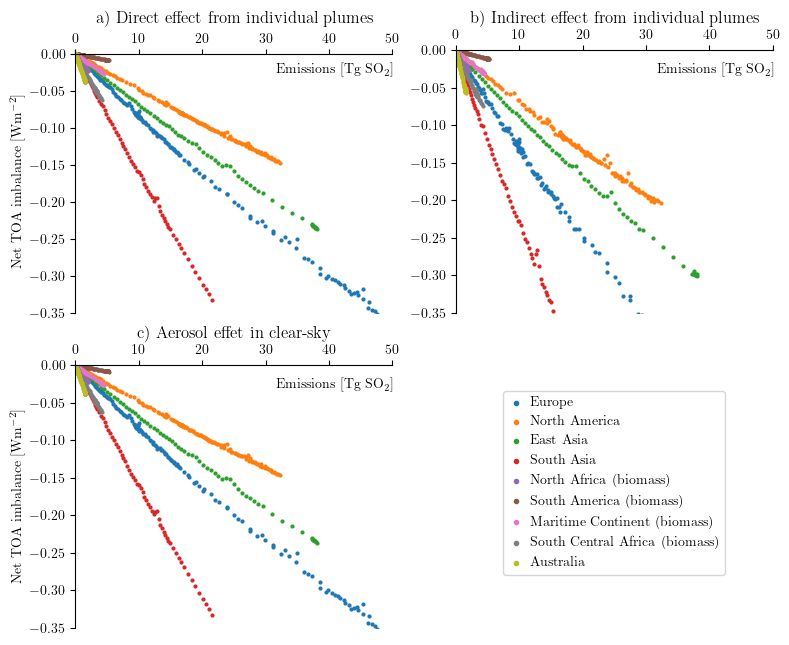

In [4]:
def plot_figure():

    dataset = xr.open_dataset('../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()
    yearmean = xr.open_dataset('../datasets/historical_simple-plumes_yearmean.nc').squeeze()

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['direct', 'indirect','clear-sky']

    for ax in [ax1, ax2, ax3]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

    ms=4

    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']
         
        ax1.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_sp{plume_number}_sraf0'] + dataset[f'dR_sp{plume_number}_traf0'], label=label, s=ms)

        clearsky = yearmean[f'dR_sp{plume_number}_sraf0'] + yearmean[f'dR_sp{plume_number}_traf0']
        clearsky_alb = clearsky*yearmean.albedo
        
        ax2.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], WeightedMean(clearsky_alb)*10, label=label, s=ms)

        ax3.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_spd{plume_number}_sraf0'] + dataset[f'dR_spd{plume_number}_traf0'], label=label, s=ms)
    
    #for effect in effects:
    #    if effect == 'direct':
    #         ax1.scatter(sum, prp[f'dR_spd_srad0'] + prp[f'dR_spd_trad0'], label='Direct effect', color=colors['direct'], s=ms)
    #    elif effect == 'indirect':
    #        ax1.scatter(sum, prp[f'dR_spi_srad0'] + prp[f'dR_spi_trad0'], label='Indirect effect', color=colors['indirect'], s=ms)
    #    elif effect == 'total':
    #        ax1.scatter(sum, prp[f'dR_sp_srad0'] + prp[f'dR_sp_trad0'], label='Total effect', color='darkorange', s=ms)    

    ax1.set_title('a) Direct effect from individual plumes', pad=20)
    ax1.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax1.xaxis.set_label_coords(.82, .95)
    ax1.set_xlim([0, 50])
    ax1.set_ylim([-0.35, 0.005])
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.set_title('b) Indirect effect from individual plumes', pad=20)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.2, 0.01])
    ax2.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax2.xaxis.set_label_coords(.82, .95)
    ax2.set_xlim([0, 50])
    ax2.set_ylim([-0.35, 0.00])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax3.set_title('c) Aerosol effet in clear-sky', pad=20)
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.xaxis.set_label_coords(.82, .95)
    ax3.set_xlim([0, 50])
    ax3.set_ylim([-0.35, 0.00])
    ax3.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)

   
    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.15,-1), markerscale=1.5)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    #fig.subplots_adjust(wspace=1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    #plt.tight_layout()
    #plt.savefig(f'../figures/forcing-vs-emissions-individual-plumes.pdf')

plot_figure()

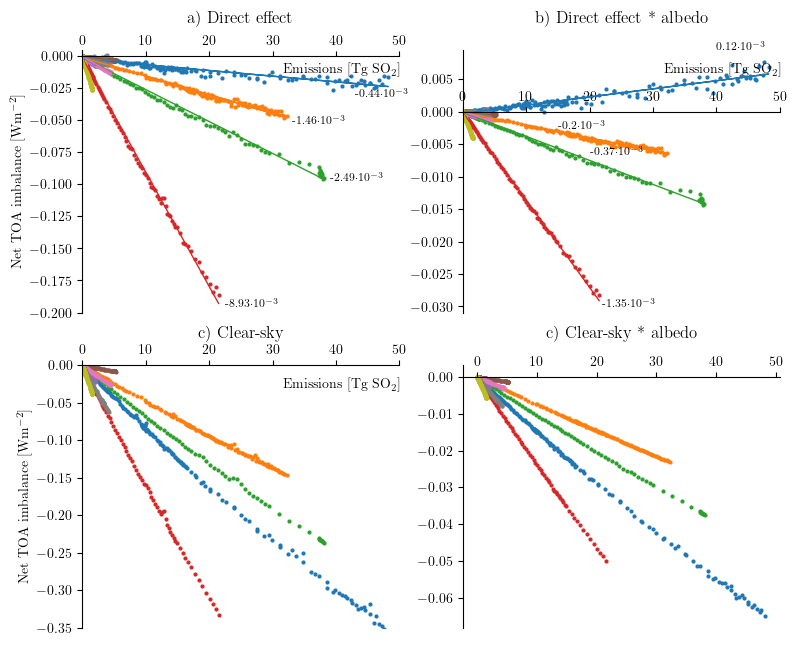

In [13]:
def plot_figure():

    dataset = xr.open_dataset('../../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()
    yearmean = xr.open_dataset('../../datasets/historical_simple-plumes_yearmean.nc').squeeze()

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['direct', 'indirect','clear-sky']

    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

    ms=4
    coefs = pd.DataFrame({'direct': [0,0,0,0,0,0,0,0,0],
                  'direct-alb': [0,0,0,0,0,0,0,0,0]},
                   index=['Europe', 'North America', 'East Asia', 'South Asia', 'North Africa', 'South America', 'Maritime Continent', 'South Central Africa',
    'Australia'])

    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']

        emission = macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005]
        forcing = dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0']
        ax1.scatter(emission, forcing, label=label, s=ms)
        X = emission.values.reshape(-1, 1)
        reg = LinearRegression().fit(X, forcing)
        ax1.plot(X, X*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
        coefs['direct'][label] = reg.coef_ 

        direct = yearmean[f'dR_spd{plume_number}_srad0'] + yearmean[f'dR_spd{plume_number}_trad0']
        albedo = - (yearmean.sraf0 - yearmean.srad0d)/(yearmean.srad0d)
        direct_alb = direct*albedo
        y = WeightedMean(direct_alb)
        reg = LinearRegression().fit(X, y)
        ax2.plot(X, X*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
        coefs['direct-alb'][label] = reg.coef_         
        ax2.scatter(emission, y, label=label, s=ms)
         
        direct = yearmean[f'dR_spd{plume_number}_srad0'] + yearmean[f'dR_spd{plume_number}_trad0']
        albedo = - (yearmean.sraf0 - yearmean.srad0d)/(yearmean.srad0d)
        direct_alb = direct*albedo
        
        #ax2.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], WeightedMean(direct_alb), label=label, s=ms)

        ax3.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_sp{plume_number}_sraf0'] + dataset[f'dR_sp{plume_number}_traf0'], label=label, s=ms)

        clearsky = yearmean[f'dR_sp{plume_number}_sraf0'] + yearmean[f'dR_sp{plume_number}_traf0']
        clearsky_alb = clearsky*albedo

        ax4.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], WeightedMean(clearsky_alb), label=label, s=ms)
    
    ax1.annotate(str(round(coefs['direct']['Europe']*1000,2))+r'$\cdot10^{-3}$', [0.86, 0.82],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['North America']*1000,2))+r'$\cdot10^{-3}$', [0.66, 0.72],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['East Asia']*1000,2))+r'$\cdot10^{-3}$', [0.78, 0.5],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['South Asia']*1000,2))+r'$\cdot10^{-3}$', [0.45, 0.02],xycoords="axes fraction", fontsize=8)

    ax2.annotate(str(round(coefs['direct-alb']['Europe']*1000,2))+r'$\cdot10^{-3}$', [0.8, 1.0],xycoords="axes fraction", fontsize=8)
    ax2.annotate(str(round(coefs['direct-alb']['North America']*1000,2))+r'$\cdot10^{-3}$', [0.3, 0.7],xycoords="axes fraction", fontsize=8)
    ax2.annotate(str(round(coefs['direct-alb']['East Asia']*1000,2))+r'$\cdot10^{-3}$', [0.4, 0.6],xycoords="axes fraction", fontsize=8)
    ax2.annotate(str(round(coefs['direct-alb']['South Asia']*1000,2))+r'$\cdot10^{-3}$', [0.44, 0.02],xycoords="axes fraction", fontsize=8)

    ax1.set_title('a) Direct effect', pad=20)
    ax1.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax1.xaxis.set_label_coords(.82, .95)
    ax1.set_xlim([0, 50])
    ax1.set_ylim([-0.2, 0.005])
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.set_title('b) Direct effect * albedo', pad=20)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.2, 0.01])
    ax2.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax2.xaxis.set_label_coords(.82, .95)
    ax2.set_xlim([0, 50])
    #ax2.set_ylim([-0.35, 0.00])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax3.set_title('c) Clear-sky', pad=20)
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.xaxis.set_label_coords(.82, .95)
    ax3.set_xlim([0, 50])
    ax3.set_ylim([-0.35, 0.00])
    ax3.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax4.set_title('c) Clear-sky * albedo', pad=20)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)

    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.15,-1), markerscale=1.5)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    #fig.subplots_adjust(wspace=1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    #plt.tight_layout()
    #plt.savefig(f'../figures/forcing-vs-emissions-individual-plumes.pdf')

plot_figure()

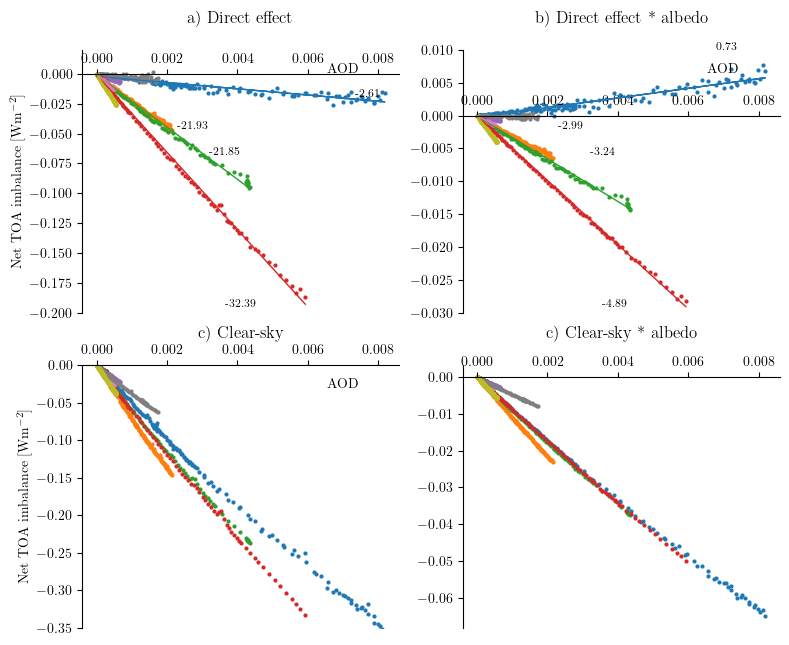

In [9]:
def plot_figure():

    dataset = xr.open_dataset('../../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()
    yearmean = xr.open_dataset('../../datasets/historical_simple-plumes_yearmean.nc').squeeze()

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['direct', 'indirect','clear-sky']

    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

    coefs = pd.DataFrame({'direct': [0,0,0,0,0,0,0,0,0],
                  'direct-alb': [0,0,0,0,0,0,0,0,0]},
                   index=['Europe', 'North America', 'East Asia', 'South Asia', 'North Africa', 'South America', 'Maritime Continent', 'South Central Africa',
    'Australia'])

    ms=4

    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']

        aod = dataset[f'aod_sp{plume_number}']
        forcing = dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0']
        ax1.scatter(aod, forcing, label=label, s=ms)
        X = aod.values.reshape(-1, 1)
        reg = LinearRegression().fit(X, forcing)
        ax1.plot(X, X*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
        coefs['direct'][label] = reg.coef_ 

        direct = yearmean[f'dR_spd{plume_number}_srad0'] + yearmean[f'dR_spd{plume_number}_trad0']
        albedo = - (yearmean.sraf0 - yearmean.srad0d)/(yearmean.srad0d)
        direct_alb = direct*albedo
        y = WeightedMean(direct_alb)
        reg = LinearRegression().fit(X, y)
        ax2.plot(X, X*reg.coef_ + reg.intercept_, linewidth=1, linestyle='-')
        coefs['direct-alb'][label] = reg.coef_         
        ax2.scatter(aod, y, label=label, s=ms)

        ax3.scatter(dataset[f'aod_sp{plume_number}'], dataset[f'dR_sp{plume_number}_sraf0'] + dataset[f'dR_sp{plume_number}_traf0'], label=label, s=ms)

        clearsky = yearmean[f'dR_sp{plume_number}_sraf0'] + yearmean[f'dR_sp{plume_number}_traf0']
        
        clearsky_alb = clearsky*albedo

        ax4.scatter(dataset[f'aod_sp{plume_number}'], WeightedMean(clearsky_alb), label=label, s=ms)

    ax1.annotate(str(round(coefs['direct']['Europe'],2)), [0.86, 0.82],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['North America'],2)), [0.3, 0.7],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['East Asia'],2)), [0.4, 0.6],xycoords="axes fraction", fontsize=8)
    ax1.annotate(str(round(coefs['direct']['South Asia'],2)), [0.45, 0.02],xycoords="axes fraction", fontsize=8)

    ax2.annotate(str(round(coefs['direct-alb']['Europe'],2)), [0.8, 1.0],xycoords="axes fraction", fontsize=8)
    ax2.annotate(str(round(coefs['direct-alb']['North America'],2)), [0.3, 0.7],xycoords="axes fraction", fontsize=8)
    ax2.annotate(str(round(coefs['direct-alb']['East Asia'],2)), [0.4, 0.6],xycoords="axes fraction", fontsize=8)
    ax2.annotate(str(round(coefs['direct-alb']['South Asia'],2)), [0.44, 0.02],xycoords="axes fraction", fontsize=8)
    

    ax1.set_title('a) Direct effect', pad=20)
    ax1.set_xlabel(r"AOD")
    ax1.xaxis.set_label_coords(.82, .95)
    #ax1.set_xlim([0, 50])
    ax1.set_ylim([-0.2, 0.02])
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.set_title('b) Direct effect * albedo', pad=20)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.2, 0.01])
    ax2.set_xlabel(r"AOD")
    ax2.xaxis.set_label_coords(.82, .95)
    #ax2.set_xlim([0, 50])
    ax2.set_ylim([-0.03, 0.01])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax3.set_title('c) Clear-sky', pad=20)
    ax3.set_xlabel(r"AOD")
    ax3.xaxis.set_label_coords(.82, .95)
    #ax3.set_xlim([0, 50])
    ax3.set_ylim([-0.35, 0.00])
    ax3.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax4.set_title('c) Clear-sky * albedo', pad=20)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)
   
    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.15,-1), markerscale=1.5)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    #fig.subplots_adjust(wspace=1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    #plt.tight_layout()
    #plt.savefig(f'../figures/forcing-vs-emissions-individual-plumes.pdf')

plot_figure()

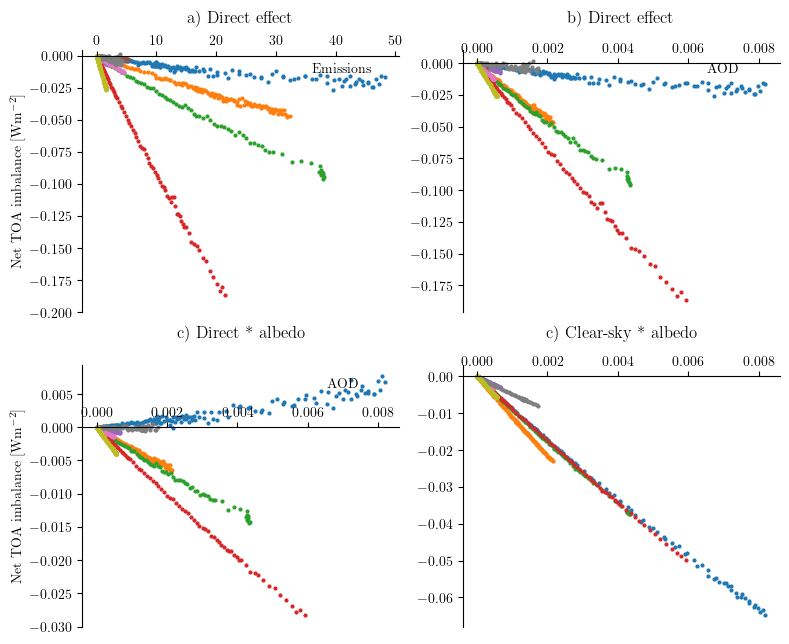

In [7]:
def plot_figure():

    dataset = xr.open_dataset('../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()
    yearmean = xr.open_dataset('../datasets/historical_simple-plumes_yearmean.nc').squeeze()

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['direct', 'indirect','clear-sky']

    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

    ms=4

    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']
         
        ax1.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0'], label=label, s=ms)

        direct = yearmean[f'dR_spd{plume_number}_srad0'] + yearmean[f'dR_spd{plume_number}_trad0']
        albedo = - (yearmean.sraf0 - yearmean.srad0d)/(yearmean.srad0d)
        direct_alb = direct*albedo
        
        ax2.scatter(dataset[f'aod_sp{plume_number}'], dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0'], label=label, s=ms)

        ax3.scatter(dataset[f'aod_sp{plume_number}'], WeightedMean(direct_alb), label=label, s=ms)

        #ax3.scatter(dataset[f'aod_sp{plume_number}'], dataset[f'dR_sp{plume_number}_sraf0'] + dataset[f'dR_sp{plume_number}_traf0'], label=label, s=ms)

        clearsky = yearmean[f'dR_sp{plume_number}_sraf0'] + yearmean[f'dR_sp{plume_number}_traf0']
        
        clearsky_alb = clearsky*albedo

        ax4.scatter(dataset[f'aod_sp{plume_number}'], WeightedMean(clearsky_alb), label=label, s=ms)

    ax1.set_title('a) Direct effect', pad=20)
    ax1.set_xlabel(r"Emissions")
    ax1.xaxis.set_label_coords(.82, .95)
    #ax1.set_xlim([0, 50])
    ax1.set_ylim([-0.2, 0.005])
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.set_title('b) Direct effect', pad=20)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.2, 0.01])
    ax2.set_xlabel(r"AOD")
    ax2.xaxis.set_label_coords(.82, .95)
    #ax2.set_xlim([0, 50])
    #ax2.set_ylim([-0.35, 0.00])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax3.set_title('c) Direct * albedo', pad=20)
    ax3.set_xlabel(r"AOD")
    ax3.xaxis.set_label_coords(.82, .95)
    #ax3.set_xlim([0, 50])
    #ax3.set_ylim([-0.2, 0.00])
    ax3.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax4.set_title('c) Clear-sky * albedo', pad=20)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)
   
    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.15,-1), markerscale=1.5)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    #fig.subplots_adjust(wspace=1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    #plt.tight_layout()
    #plt.savefig(f'../figures/forcing-vs-emissions-individual-plumes.pdf')

plot_figure()

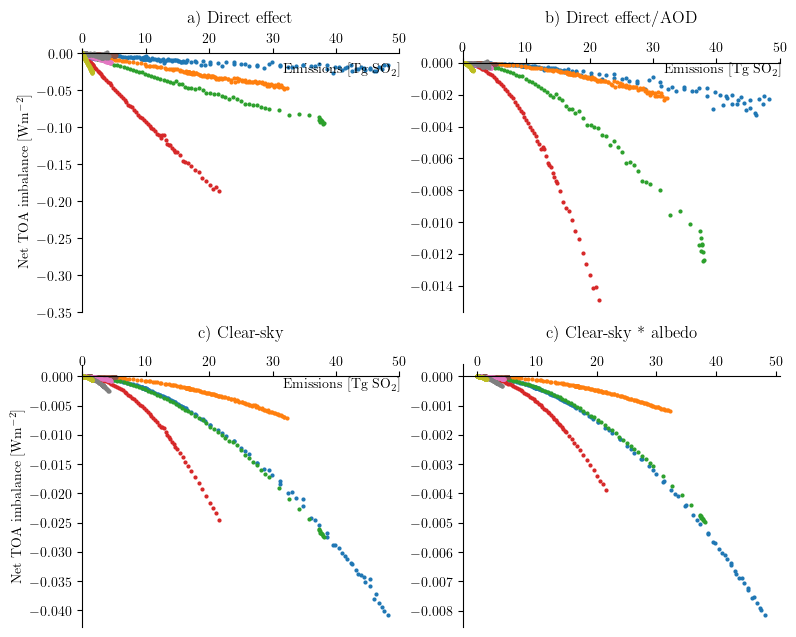

In [19]:
def plot_figure():

    dataset = xr.open_dataset('../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()
    yearmean = xr.open_dataset('../datasets/historical_simple-plumes_yearmean.nc').squeeze()

    fig = plt.figure()
    gs = GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    #fig.delaxes(gs[1, 1])

    subplots = {'direct': ax1,
                 'indirect': ax2,
                 'clear-sky':ax3}

    effects = ['direct', 'indirect','clear-sky']

    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

    ms=4

    for plume_number in range(1, 10, 1):
        label=macsp.attrs[f'plume{plume_number}_region']
         
        ax1.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], dataset[f'dR_spd{plume_number}_srad0'] + dataset[f'dR_spd{plume_number}_trad0'], label=label, s=ms)

        direct = yearmean[f'dR_spd{plume_number}_srad0'] + yearmean[f'dR_spd{plume_number}_trad0']
        direct_aod = direct*yearmean[f'aod_sp{plume_number}']
        albedo = - (yearmean.sraf0 - yearmean.srad0d)/(yearmean.srad0d)
        direct_alb = direct*albedo
        
        #ax2.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], WeightedMean(direct_alb), label=label, s=ms)
        ax2.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], WeightedMean(direct_aod), label=label, s=ms)

        clearsky = yearmean[f'dR_sp{plume_number}_sraf0'] + yearmean[f'dR_sp{plume_number}_traf0']
        clearsky_aod = clearsky*yearmean[f'aod_sp{plume_number}']

        ax3.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], WeightedMean(clearsky_aod), label=label, s=ms)

        
        clearsky_alb = clearsky_aod*albedo

        ax4.scatter(macsp.year_weight.sel(plume_number=plume_number).isel(years=slice(0,164))*emissions.iloc[:, plume_number-1].loc[2005], WeightedMean(clearsky_alb), label=label, s=ms)
    
    ax1.set_title('a) Direct effect', pad=20)
    ax1.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax1.xaxis.set_label_coords(.82, .95)
    ax1.set_xlim([0, 50])
    ax1.set_ylim([-0.35, 0.005])
    ax1.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax1.tick_params(axis='x', direction='in', which='major', pad=-15)
    
    #ax2.tick_params(labelleft = False, labelright=False)
    ax2.set_title('b) Direct effect/AOD', pad=20)
    #ax2.set_xlim([1850, 2014])
    #ax2.set_ylim([-0.35, 0.01])
    ax2.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax2.xaxis.set_label_coords(.82, .95)
    ax2.set_xlim([0, 50])
    #ax2.set_ylim([-0.35, 0.00])
    #ax2.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    #ax2.yaxis.set_label_coords(1, -.08)
    #ax2.yaxis.tick_right()
    ax2.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax3.set_title('c) Clear-sky', pad=20)
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.xaxis.set_label_coords(.82, .95)
    ax3.set_xlim([0, 50])
    #ax3.set_ylim([-0.35, 0.00])
    ax3.set_ylabel("Net TOA imbalance [Wm$^{-2}$]")  
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)

    ax4.set_title('c) Clear-sky * albedo', pad=20)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)

    leg = ax2.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(.15,-1), markerscale=1.5)
    leg.set_zorder(1)
    
    fig = plt.gcf()
    fig.set_size_inches(9, 7.5)
    #fig.subplots_adjust(wspace=1)
    #plt.title('Gregory-regression difference between 2005 and 1970 \nin abrupt-aerosol experiments')
    #plt.tight_layout()
    #plt.savefig(f'../figures/forcing-vs-emissions-individual-plumes.pdf')

plot_figure()